# Проект Викишоп с использованием Distilbert

Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.

## Ознакомление с данными

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
import torch
import transformers
import re
from sklearn.metrics import f1_score

In [2]:
try:
    data = pd.read_csv(r'C:\Users\Lenovo\Desktop\data\локальные проекты\toxic_comments\исходник проекта toxic coments\toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
display(data)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [4]:
data.duplicated().sum()

0

In [5]:
data.isna().sum()

text     0
toxic    0
dtype: int64

Дубликатов и пропусков в файле нет - это хорошо

Посмотрим разброс по длине предложений в датафрейме

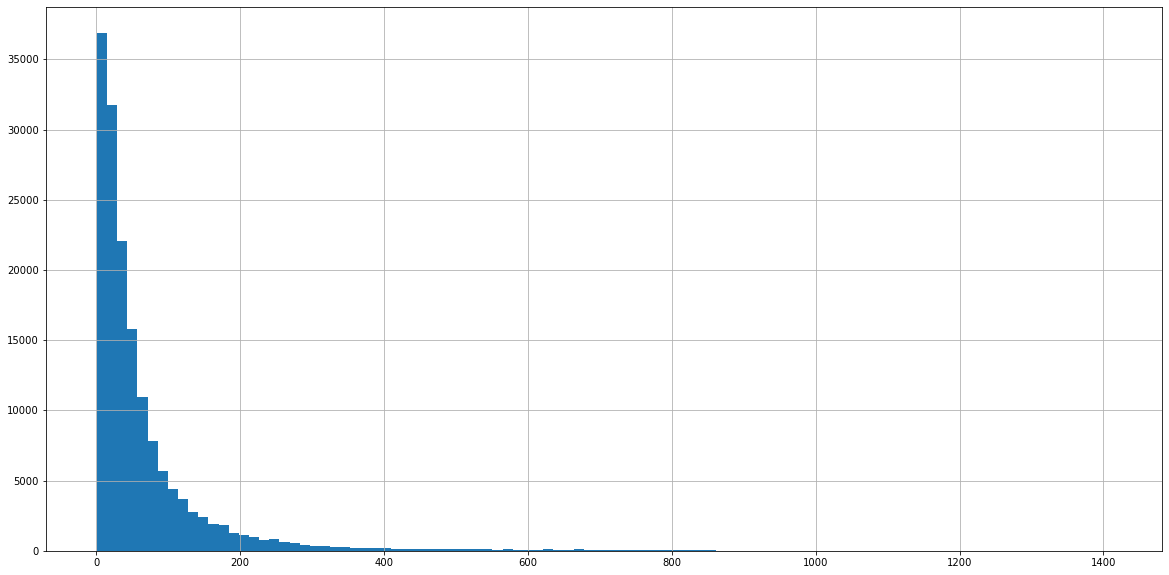

In [6]:
words_in_text = []
for i in range(len(data)):
  number_of_words = len(data.loc[i, 'text'].split())
  words_in_text.append(number_of_words)

data['number_of_words'] = pd.Series(words_in_text)
data['number_of_words'].hist(bins=100, figsize = (20, 10));

Из-за недоступности мощностей - было принято решение в учебных целях рассмотреть только 1000 строк

Отсечём от датафрейма для начала предложения с кол-вом слов выше 200, так как таких сравнительно немного, да и такие выбросы усложняю как минимум процесс токенизации, а затем из этого датафрейма с приемлемыми по длине предложениями выберем случайные 1 000 сэмплов

In [7]:
data = data.query('number_of_words < 200')

In [8]:
del data['number_of_words']

In [9]:
data.shape

(149403, 2)

In [10]:
data = data.sample(1000)

In [11]:
data['toxic'].value_counts()

0    898
1    102
Name: toxic, dtype: int64

что ж, баланс классов более-менее приемлемый

Как я заметил позже на токенизации - из-за довольно большого числа лишних символов в текстах число токенов очень сильно расчёт. Например при 150 слов может быть больше 2000 токенов, что весьма усложняет процесс. Ради интереса попробовал через регулярные выражения убрать все символы, включая лишнюю табуляцию, которая фигурирует в виде "\n" чуть ли не в половине строк:

In [12]:
display(data)

,text,toxic
109008,"To Hersfold, I admitted NO SUCH THING. I have ...",0
27214,you fuck misterwiki. you fuck misterwiki. ...,1
23996,Requested move \n\n .300 WSM → .300 Winchester...,0
137433,You are guilty of trolling and edit warring \n...,0
107403,"""\n""""You are an asset...""""' If you take off th...",0
...,...,...
93528,The reason that Morocco is not a member of the...,0
93928,I am not being abusive! 124.181.65.132,0
158996,"""==DJ Sammy==\nCan I please suggest you read W...",0
95816,DO \n\nI see you have signed up for the last d...,0


In [13]:
def clear_text(text):
  pattern = r'\\n'     # отдельно выделим табуляцию через \n, так как просто удалив лишние "\" останется куча лишних n
  replacement = ' '
  cleared_tabs = re.sub(pattern, replacement, text)
  pattern = r'[^a-zA-Z0-9]'                             # оставим только числа и буквы
  replacement = ' '
  cleared = re.sub(pattern, replacement, cleared_tabs)
  whitespaces_fixed = ' '.join(cleared.split())
  return whitespaces_fixed

In [14]:
data['text'] = data['text'].apply(clear_text)

In [15]:
display(data)

,text,toxic
109008,To Hersfold I admitted NO SUCH THING I have ne...,0
27214,you fuck misterwiki you fuck misterwiki you fu...,1
23996,Requested move 300 WSM 300 Winchester Short Ma...,0
137433,You are guilty of trolling and edit warring Ki...,0
107403,You are an asset If you take off the et part I...,0
...,...,...
93528,The reason that Morocco is not a member of the...,0
93928,I am not being abusive 124 181 65 132,0
158996,DJ Sammy Can I please suggest you read Wikiped...,0
95816,DO I see you have signed up for the last drama...,0


Что ж - датафрейм выглядит уже гораздо более человечно. Попробуем сделать токенизацию

## Токенизация текста для загрузки в Distilbert

In [16]:
model_class = transformers.DistilBertModel
tokenizer_class = transformers.DistilBertTokenizer
pretrained_weights = 'distilbert-base-uncased'

In [17]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
tokenized_text = data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

Далее, насколько я понял - мы хотим подогнать весь текст для скармливания Bert'у под единый батч одного размера, так как это должно ускорить процесс, нежели отправлять ему каждую строку датафрейма поотдельности. И ключевым моментом в данном процессе является определить текст с самым большим размером, именно от него оттолкнувшишь для выбора размера массива, а все меньше строки "подогнать" под этот размер докидыванием в них нулей.

In [19]:
max_len = 0
for i in tokenized_text.values:
  if len(i) > max_len:
    max_len = len(i)

padded_text = np.array([i + [0]*(max_len-len(i)) for i in tokenized_text.values])

In [20]:
padded_text.shape

(1000, 236)

Далее следует ещё один манёвр - просто так подать в Bert массив, который был создан - нельзя. Мы должны подсказать модели тот факт, что докидывали лишние нули для подгонки массива, и на них не нужно обращать вниманием при обучении, так как модель естественно не сумеет догадаться самостоятельно откуда эти нули взялись. И для этой самой подсказки создаётся ещё один массив из 0 и 1, где 1 сигнализирует наличие на этой позиции информативного, полезного токена с информацией о тексте, а 0 - как раз говорит о том что на данной позиции те самые подогнанные 0 без смысловой нагрузки.

In [21]:
attention_mask = np.where(padded_text != 0, 1, 0)
attention_mask.shape

(1000, 236)

Размерности массивов совпали - значит по идее всё идёт верно - можно их использовать для помещения в модель Bert'a

## Загрузка данных в Distilbert

In [22]:
input_ids = torch.tensor(padded_text)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
  last_hidden_states = model(input_ids, attention_mask=attention_mask)

Результат скармливания DistilBert'у token'ов и attention_mask сохраняется им, судя по данным в интернете - во что-то вроде кубического массива, из которого нам нужно достать для каждой строчки только токен, который был самым первым

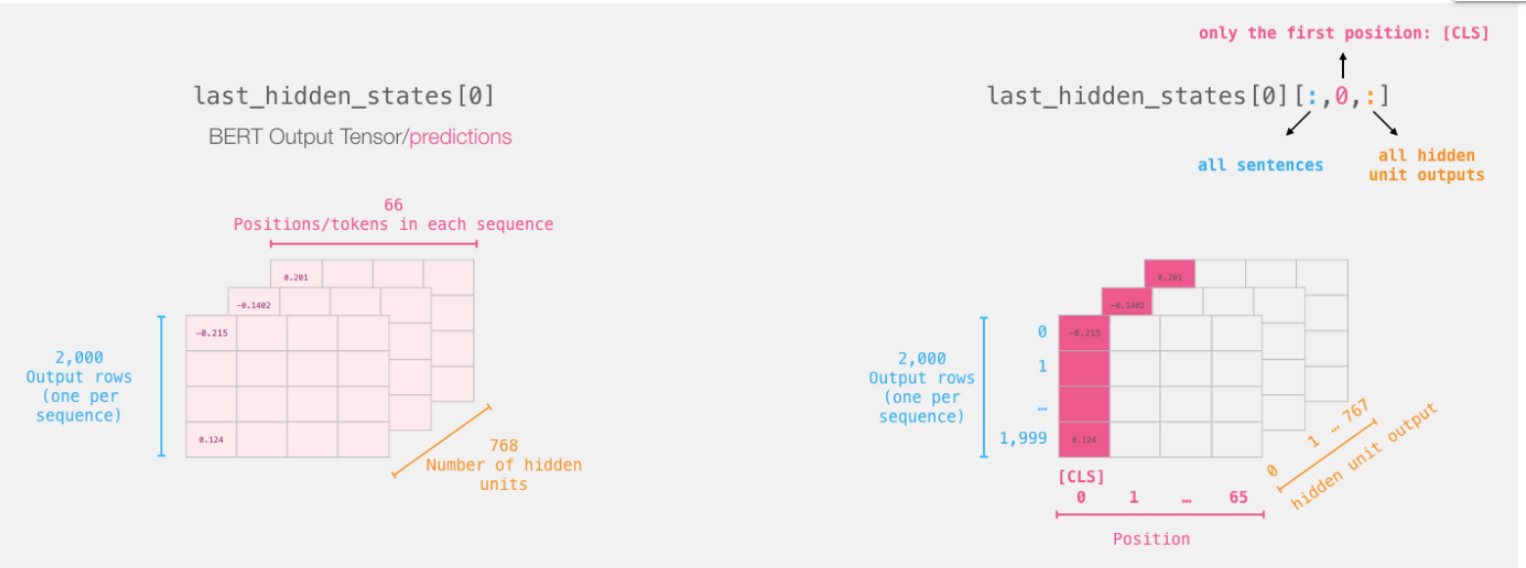

In [23]:
features = last_hidden_states[0][:, 0, :].numpy()

Запишем целевой признак:

In [24]:
target = data['toxic']

## Обучение CatboostClassifier на полученных признаках:

Разобьём тестовую и тренировочную выборки на 80 % и 20 % от исходных данных, визуализируем результаты, и для того чтобы не перегружать и так уставшую систему введём параметр early_stopping_rounds, шаг сделаем так же побольше:

In [25]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.2)

In [26]:
classification_model = CatBoostClassifier(iterations = 100, 
                                          random_seed = 0, 
                                          learning_rate = 0.5,
                                          eval_metric = 'F1',
                                          early_stopping_rounds = 20
                                         )

In [27]:
classification_model.fit(train_features, train_target,
                         verbose = False,
                        plot = True,
                        eval_set = (test_features, test_target))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [28]:
classification_model.tree_count_

17

In [29]:
predictions = classification_model.predict(test_features)

In [30]:
f1_score = f1_score(test_target, predictions)

In [31]:
print(f'Метрика F1 обученной модели при её проверке на тестовой части: {f1_score:.3f}')

Метрика F1 обученной модели при её проверке на тестовой части: 0.815


In [32]:
f1_min_score = 0.75 # минимальное требуемое значение f1 по условию задания

In [33]:
if f1_score > f1_min_score:
    print('Нужное качество модели достигнуто')
else:
    print('Не достигнуто нужное качество модели')

Нужное качество модели достигнуто


Что ж, модель показала необходимую точность даже на итоговом небольшом наборе данных